In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [98]:
df = pd.read_csv("flight_delay.csv")

In [99]:
df.head(8)

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0
5,HAM,2015-10-27 14:30:00,SVO,2015-10-27 17:15:00,0.0
6,SVO,2015-10-27 14:35:00,JFK,2015-10-28 01:25:00,0.0
7,DXB,2015-10-27 15:40:00,SVO,2015-10-27 21:20:00,1.0


In [100]:
df["Scheduled depature time"]= pd.to_datetime(df["Scheduled depature time"])
df["Scheduled arrival time"] = pd.to_datetime(df["Scheduled arrival time"])
df["FlyDuration"] = df["Scheduled arrival time"] - df ["Scheduled depature time"]
df["FlyDuration"] = df["FlyDuration"]  / np.timedelta64(1, 'm')
y = df.Delay

In [101]:



df['ScheduledDep_year'] = df["Scheduled depature time"].dt.year
df['ScheduledDep_month'] = df["Scheduled depature time"].dt.month
df['ScheduledDep_week'] = df["Scheduled depature time"].dt.isocalendar().week
df['ScheduledDep_day'] = df["Scheduled depature time"].dt.day
df['ScheduledDep_hour'] = df["Scheduled depature time"].dt.hour
df['ScheduledDep_minute'] = df["Scheduled depature time"].dt.minute
df['ScheduledDep_dayofweek'] = df["Scheduled depature time"].dt.dayofweek

df['ScheduledArr_year'] = df["Scheduled arrival time"].dt.year
df['ScheduledArr_month'] = df["Scheduled arrival time"].dt.month
df['ScheduledArr_week'] = df["Scheduled arrival time"].dt.isocalendar().week
df['ScheduledArr_day'] = df["Scheduled arrival time"].dt.day
df['ScheduledArr_hour'] = df["Scheduled arrival time"].dt.hour
df['ScheduledArr_minute'] = df["Scheduled arrival time"].dt.minute
df['ScheduledArr_dayofweek'] = df["Scheduled arrival time"].dt.dayofweek


del df["Scheduled depature time"]
del df["Scheduled arrival time"]
del df["Delay"]
#df["Day_of_dep_t"] = df["Scheduled depature time"].dt.day_name()
#df.drop(["Delay"],axis=1)
#x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)




In [102]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df["Depature Airport"]= le.fit_transform(df["Depature Airport"])
df["Destination Airport"] = le.fit_transform(df["Destination Airport"])

df_train = df[df["ScheduledDep_year"]<2018]
df_test =  df[df["ScheduledDep_year"]==2018]

y_train = y[df_train.index]
y_test = y[df_test.index]

pca = PCA(n_components=1, svd_solver='arpack')
most_val_vec = pca.fit_transform(df_train)



Text(0.5, 1.0, 'Correlation')

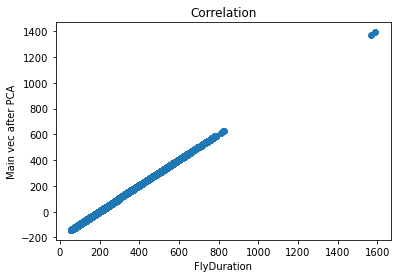

In [103]:
d_t = df_train.FlyDuration
plt.scatter(d_t, most_val_vec)
plt.xlabel('FlyDuration')
plt.ylabel('Main vec after PCA')
plt.title("Correlation")

Text(0, 0.5, 'delay')

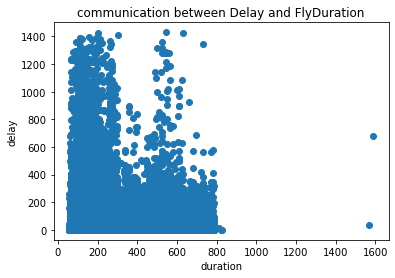

In [104]:
plt.title('communication between Delay and FlyDuration')
plt.scatter(df_train["FlyDuration"] , y_train)
plt.xlabel('duration')
plt.ylabel('delay')

Text(0.5, 1.0, 'Hist for finding noise points in train')

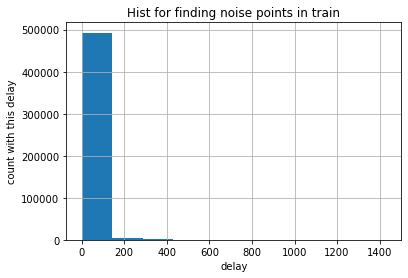

In [105]:
y_train.hist() 
plt.xlabel('delay')
plt.ylabel('count with this delay')
plt.title("Hist for finding noise points in train")

In [106]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures #to convert the original features into their higher order terms 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


In [107]:
lr = LinearRegression()
lr.fit(df_train,y_train)
y_pred = lr.predict(df_test)
print("MSE with all data: ", mean_squared_error(y_pred,y_test))
print("MAE with all data: ", mean_absolute_error(y_pred,y_test))
lr = LinearRegression()
lr.fit(df_train.FlyDuration.values.reshape(-1,1) ,y_train)
y_pred = lr.predict(df_test.FlyDuration.values.reshape(-1,1))
print("MSE using just FlyDuration: ",  mean_squared_error(y_pred,y_test))
print("MAE using just FlyDuration:", mean_absolute_error(y_pred,y_test))

MSE with all data:  1644.5433782686932
MAE with all data:  16.16071286562617
MSE using just FlyDuration:  1619.2068848222061
MAE using just FlyDuration: 14.401651841266302


In [108]:
def detect_noise(delays, m_o_d  ):
    """ 
    this func finds and returns noise_point,index_noise 
    delays - our target
    m_o_d - possible indentation spacing from mean_of_data """
    i=0
    ind = delays.index.values
    mean_of_delays = delays.mean()
    noise_point = []
    index_noise=[]
    for delay  in delays.values :
        if delay > (m_o_d + mean_of_delays):
            noise_point.append(delay)
            index_noise.append(ind[i])
        i+=1
    return noise_point,index_noise    

In [109]:
noise , ind = detect_noise(delays = y_train, m_o_d  = 50)

In [110]:
#df_train = df_train.reset_index()
#y_train = y_train.reset_index()
df_train  = df_train.drop(ind)
y_train = y_train.drop(ind)


In [111]:
models = [linear_model.Lasso(),linear_model.Ridge(),LinearRegression()]
names = ["Lasso" , "Ridge", "LinearRegr_without_reg"]
mae = {"mae_for_Lasso":[],"mae_for_Ridge":[],"mae_for_LinearRegr_without_reg":[]}
mse = {"mse_for_Lasso":[],"mse_for_Ridge":[],"mse_for_LinearRegr_without_reg":[]}
r2 = {"r2_for_Lasso":[],"r2_for_Ridge":[],"r2_for_LinearRegr_without_reg":[]}
degrees = [1, 2, 5 , 8 ,10]
k=0
for model in models:
    for i in range (len(degrees)):
        polynomial_features = PolynomialFeatures(degree=degrees[i])
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             (names[k], model)])
        y_pred = pipeline.fit(df_train.FlyDuration.values.reshape(-1,1), y_train).predict(df_train.FlyDuration.values.reshape(-1,1))
        r2["r2_for_"+names[k]].append(metrics.r2_score(y_train, y_pred))
        mae["mae_for_"+names[k]].append(mean_absolute_error(y_train, y_pred))
        mse["mse_for_"+names[k]].append(mean_squared_error(y_train,y_pred))
    k+=1
   
    

/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23763215.838771712, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23761794.481633276, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23761615.11651154, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: Lin

In [112]:
d1= {"Polyn_degrees ": degrees}
err = dict(mae, **mse)
err.update(r2)
err.update(d1)

errors = pd.DataFrame(err)
#errors.to_latex("err_on_train.tex")

In [113]:
writer = pd.ExcelWriter('for_train.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
errors.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

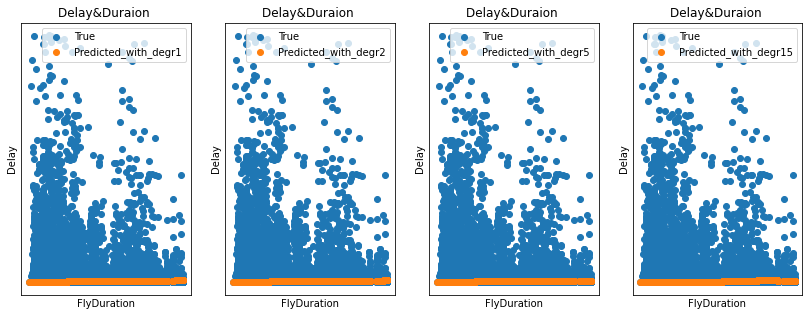

In [114]:
degrees = [1, 2, 5 ,15]
model = LinearRegression()
k= 0 
plt.figure(figsize=(14, 5))

for i in range (len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)
        plt.setp(ax, xticks=(), yticks=())
        polynomial_features = PolynomialFeatures(degree=degrees[i])
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", model)])
        y_pred = pipeline.fit(df_train.FlyDuration.values.reshape(-1,1), y_train).predict(df_test.FlyDuration.values.reshape(-1,1))
      
        plt.scatter(df_test.FlyDuration.values.reshape(-1,1) , y_test ,  label  = "True")
        plt.scatter(df_test.FlyDuration.values.reshape(-1,1) , y_pred , label =  "Predicted_with_degr{}".format(degrees[i]))
       # plt.plot(intervals , mse["mse_for_LinearRegr_without_reg"] , label = 'SimpleLinearRegr')
        plt.legend(loc="best")
        plt.title('Delay&Duraion ')
        plt.xlabel('FlyDuration')
        plt.ylabel("Delay")     
        k+=1
plt.show()        

Text(0.5, 1.0, 'Hist for finding noise points on test')

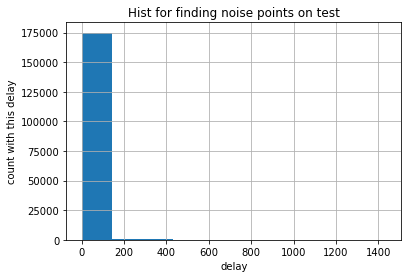

In [115]:
y_test.hist()
plt.xlabel('delay')
plt.ylabel('count with this delay')
plt.title("Hist for finding noise points on test")

In [116]:
print(len(y_test))
print(len(y_test[y_test<100]))

176451
174049


In [117]:
#So we have some noise points  - 

In [118]:
models = [linear_model.Lasso(),linear_model.Ridge(),LinearRegression()]
names = ["Lasso" , "Ridge", "LinearRegr_without_reg"]
mae = {"mae_for_Lasso":[],"mae_for_Ridge":[],"mae_for_LinearRegr_without_reg":[]}
mse = {"mse_for_Lasso":[],"mse_for_Ridge":[],"mse_for_LinearRegr_without_reg":[]}
r2 = {"r2_for_Lasso":[],"r2_for_Ridge":[],"r2_for_LinearRegr_without_reg":[]}
degrees = [1, 2, 5 , 8 ,10]
k=0
for model in models:
    for i in range (len(degrees)):
        polynomial_features = PolynomialFeatures(degree=degrees[i])
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             (names[k], model)])
        y_pred = pipeline.fit(df_train.FlyDuration.values.reshape(-1,1), y_train).predict(df_test.FlyDuration.values.reshape(-1,1))
        r2["r2_for_"+names[k]].append(metrics.r2_score(y_test, y_pred))
        mae["mae_for_"+names[k]].append(mean_absolute_error(y_test, y_pred))
        mse["mse_for_"+names[k]].append(mean_squared_error(y_test,y_pred))
    k+=1
   
    

/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23763215.838771712, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23761794.481633276, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23761615.11651154, tolerance: 4847.95128860544
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: Lin

In [119]:
d1= {"Polyn_degrees ": degrees}
err = dict(mae, **mse)
err.update(r2)
err.update(d1)

errors = pd.DataFrame(err)
writer = pd.ExcelWriter('for_test.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
errors.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [120]:
#UDDATE

df_train = df[df["ScheduledDep_year"]<2018]
df_test =  df[df["ScheduledDep_year"]==2018]
y_train = y[df_train.index]
y_test = y[df_test.index]

In [121]:
intervals = [5.5 ,15 , 30 , 50 , 90 , 220, 300, 500, 700 , 1000]
models = [linear_model.Lasso(),linear_model.Ridge(),LinearRegression()]
names = ["Lasso" , "Ridge", "LinearRegr_without_reg"]
X = df_train.values
mae = {"mae_for_Lasso":[],"mae_for_Ridge":[],"mae_for_LinearRegr_without_reg":[]}
mse = {"mse_for_Lasso":[],"mse_for_Ridge":[],"mse_for_LinearRegr_without_reg":[]}
r2 = {"r2_for_Lasso":[],"r2_for_Ridge":[],"r2_for_LinearRegr_without_reg":[]}
models = [linear_model.Lasso(),linear_model.Ridge(),LinearRegression()]
k=0
for model in models:
    for interval in intervals : 
        noise , idex =  detect_noise(y_train , interval)
        df_t=df_train.drop(idex)
        y_t = y_train.drop(idex)
        model.fit(df_t.FlyDuration.values.reshape(-1,1),y_t)
        y_pred = model.predict(df_test.FlyDuration.values.reshape(-1,1))
        r2["r2_for_"+names[k]].append(metrics.r2_score(y_test, y_pred))
        mae["mae_for_"+names[k]].append(mean_absolute_error(y_test, y_pred))
        mse["mse_for_"+names[k]].append(mean_squared_error(y_test,y_pred))
        
    k+=1    

Text(0, 0.5, 'MSE')

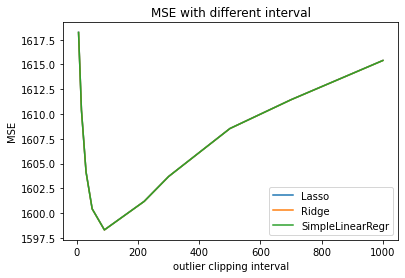

In [122]:
plt.plot(intervals , mse["mse_for_Lasso"] ,  label  = "Lasso")
plt.plot(intervals , mse["mse_for_Ridge"] , label = 'Ridge')
plt.plot(intervals , mse["mse_for_LinearRegr_without_reg"] , label = 'SimpleLinearRegr')
plt.legend(loc="best")
plt.title('MSE with different interval')
plt.xlabel('outlier clipping interval')
plt.ylabel("MSE") 

Text(0, 0.5, 'R2')

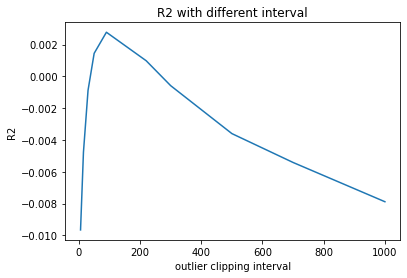

In [123]:
plt.plot(intervals , r2["r2_for_Lasso"] , label = 'Ridge')
plt.title('R2 with different interval')
plt.xlabel('outlier clipping interval')
plt.ylabel("R2") 

No handles with labels found to put in legend.


Text(0, 0.5, 'MAE')

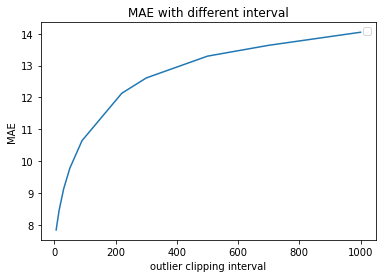

In [124]:
plt.plot(intervals , mae["mae_for_Lasso"] )
plt.legend(loc="best")
plt.title('MAE with different interval')
plt.xlabel('outlier clipping interval')
plt.ylabel("MAE") 

In [125]:
print(np.array(r2["r2_for_Lasso"]).argmax())
print(np.array(mse["mse_for_Lasso"]).argmin())
best_interv = intervals[np.array(mse["mse_for_Lasso"]).argmin()]
print("Best interval : " , best_interv)

4
4
Best interval :  90


In [126]:
noise , idex =  detect_noise(y_train , best_interv)
df_train  = df_train.drop(idex)
y_train = y_train.drop(idex)
noise , idex =  detect_noise(y_test , 60)
y_without_some_noise = y_test.drop(idex)
df_new_test  = df_test.drop(idex)

In [127]:
models = [linear_model.Lasso(),linear_model.Ridge(),LinearRegression()]
names = ["Lasso" , "Ridge", "LinearRegr_without_reg"]
mae = {"mae_for_Lasso":[],"mae_for_Ridge":[],"mae_for_LinearRegr_without_reg":[]}
mse = {"mse_for_Lasso":[],"mse_for_Ridge":[],"mse_for_LinearRegr_without_reg":[]}
r2 = {"r2_for_Lasso":[],"r2_for_Ridge":[],"r2_for_LinearRegr_without_reg":[]}
degrees = [1, 2, 5 , 8 ,10]
k=0
for model in models:
    for i in range (len(degrees)):
        polynomial_features = PolynomialFeatures(degree=degrees[i])
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             (names[k], model)])
        y_pred = pipeline.fit(df_train.FlyDuration.values.reshape(-1,1), y_train).predict(df_new_test.FlyDuration.values.reshape(-1,1))
        r2["r2_for_"+names[k]].append(metrics.r2_score(y_without_some_noise, y_pred))
        mae["mae_for_"+names[k]].append(mean_absolute_error(y_without_some_noise, y_pred))
        mse["mse_for_"+names[k]].append(mean_squared_error(y_without_some_noise,y_pred))
    k+=1
   
    

/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44970261.89729263, tolerance: 9129.477423270058
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44967884.315469466, tolerance: 9129.477423270058
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44967338.29300905, tolerance: 9129.477423270058
  model = cd_fast.enet_coordinate_descent(
/home/aidar/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: L

In [128]:
d1= {"Polyn_degrees ": degrees}
err = dict(mae, **mse)
err.update(r2)
err.update(d1)

errors = pd.DataFrame(err)
writer = pd.ExcelWriter('for_test_after_updating.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
errors.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()